In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn
from config import *
from load_data import getTrainingSet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FeedForwardNN(nn.Module):
    def __init__(self, input_size, size_of_hidden_layers, output_size):
        super(FeedForwardNN, self).__init__()
        self.size_of_hidden_layers = size_of_hidden_layers
        self.fc1 = nn.Linear(input_size, size_of_hidden_layers[0])
        for i in range(1, len(size_of_hidden_layers)):
            setattr(
                self, f'fc{i+1}', nn.Linear(size_of_hidden_layers[i-1], size_of_hidden_layers[i]))

        self.out = nn.Linear(size_of_hidden_layers[-1], output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        for i in range(1, len(self.size_of_hidden_layers)):
            fc= getattr(self, f'fc{i+1}')
            x = self.relu(fc(x))
        x = self.out(x)
        return x

In [4]:

def train_model(model, train_loader, epochs, optimizer, loss_function, verbose=False, save_model=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        outputs = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            # unroll the sequence
            x = x.view(x.size(0), -1)
            output = model.forward(x)
            output = output.squeeze(1)
            loss = loss_function(output, y)
            loss.backward()
            optimizer.step()
            if verbose and i % (x.size(0)*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//x.size(0)} loss: {loss.item()}')
            epoch_losses.append(loss.item())
            outputs.append(output)
        losses.append(np.mean(epoch_losses))
        print(f'Epoch {epoch} loss: {losses[-1]}')
    if save_model:
        torch.save(model.state_dict(), 'model.pth')
    return losses, outputs

In [5]:
dataset = getTrainingSet(reshape=False, sequence_length=24)
features = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
input_size = features * sequence_length
size_of_hidden_layers = SIZE_OF_HIDDEN_LAYERS_FNN
output_size = OUTPUT_SIZE
epochs = EPOCHS_FNN
learning_rate = LEARNING_RATE
batch_size = BATCH_SIZE

model = FeedForwardNN(input_size, size_of_hidden_layers, output_size)
loss_function = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=False)
losses, outputs = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    verbose=True,
    save_model=True
)


In [ ]:
plt.plot(losses)
# new_epochs = range(0, len(losses), len(losses)//epochs)
# for epoch in new_epochs:
#     plt.axvline(x=epoch, color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

[-1.63083677  1.25722874 -0.7652773  -1.3745722  -0.08446891 -0.29930838]
[ 0.29769143 -0.32521522 -0.57826943 -0.96876766 -0.34552883 -0.75300503
  1.04370947 -0.85129423  0.37523341 -0.96861349 -0.492596    1.22500103
 -0.95677088 -1.41211093 -0.81056736 -0.53072795  0.59103279 -0.14515618
  0.72426989 -0.07647151 -0.60346474 -1.26022422 -0.61073728 -0.90097089]
[0.38470661640167236, -0.21404202282428741, -0.633391797542572, -0.9732480049133301, -0.28912192583084106, -0.7237013578414917, 0.9721488952636719, -0.9073038101196289, 0.29440659284591675, -0.9937514066696167, -0.49983763694763184, 1.2353858947753906, -0.9240226745605469, -1.4902756214141846, -0.8095893859863281, -0.31707364320755005, 0.6750004291534424, -0.19517333805561066, 0.694476306438446, -0.012053295969963074, -0.6120722889900208, -1.2557456493377686, -0.6774517893791199, -0.8519145250320435]


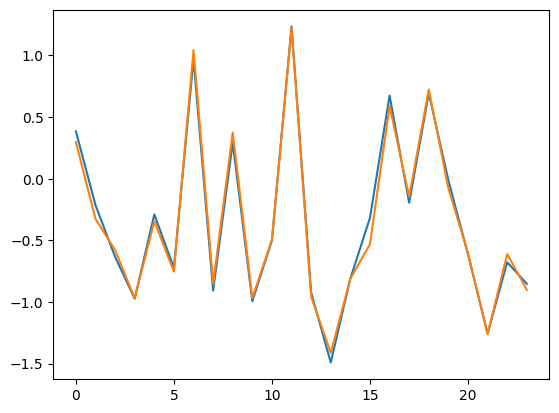

In [24]:
from load_data import getTestData
model.load_state_dict(torch.load('model.pth'))

model.eval()

data = getTestData()

print(data[0][1])
print(data[1][:24])
data = (data[0].astype(np.float32), data[1])
def predict_one_horizon(model, X_test, given_cases,forecast_horizon):
    predictions = []
    assert len(X_test) == forecast_horizon+given_cases
    for i in range(forecast_horizon):
        x = torch.tensor(X_test[i:i+forecast_horizon]).to(device)
        x = x.view(1, -1)
        output = model.forward(x)
        predictions.append(output.item())
        X_test[i+forecast_horizon][-1] = output.item()
    return predictions


preds=predict_one_horizon(model, data[0][:48], 24, 24)
print(preds[0:24])
plt.plot(preds)
plt.plot(data[1][:24])


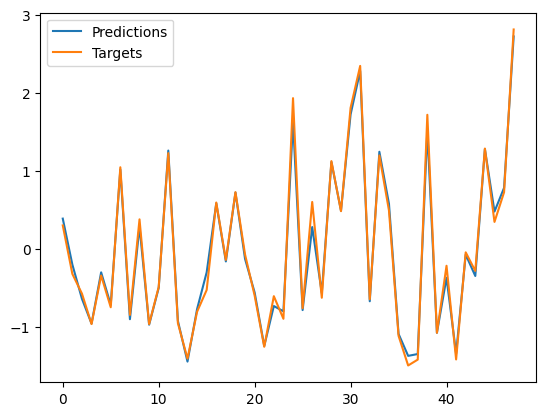

In [50]:
def plot_predictions(predictions, targets):
    plt.plot(predictions[:48], label='Predictions')
    plt.plot(targets[:48], label='Targets')
    plt.legend()
    plt.show()
    
plot_predictions(predictions, targets)